# ML Assignment - CIFAR10
### By: Francisco Javier Sánchez Vadillo
### Date: 08/01/2025


## Imports and Device check

In [1]:
# Importing libraries
import torch
from torch import nn, optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

# Check device
if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")
    
print(f"Using device: {device}")

Using device: mps


## Download the CIFAR10 dataset and create a DataLoader

In [2]:

# Load CIFAR-10 dataset and apply transformations
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32, padding=4),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Download training and test data
train_data = datasets.CIFAR10(root="data", train=True, download=True, transform=transform)
test_data = datasets.CIFAR10(root="data", train=False, download=True, transform=transform)

# Create data loaders
batch_size = 64
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)


Files already downloaded and verified
Files already downloaded and verified


## Neural Networks and initialization of the model

In [3]:

# Define the neural network
class OptimizedCNN(nn.Module):
    def __init__(self):
        super(OptimizedCNN, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout(0.25)
        )
        self.fc_layers = nn.Sequential(
            nn.Linear(64 * 16 * 16, 256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, 10)
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = x.view(x.size(0), -1)  # Flatten the tensor
        x = self.fc_layers(x)
        return x

# Initialize the model, loss function, and optimizer
model = OptimizedCNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


## Training a CNN on CIFAR10 dataset

In [4]:

# Training the model
epochs = 10

for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
    
    print(f"Epoch [{epoch+1}/{epochs}], Loss: {running_loss/len(train_loader):.4f}")


Epoch [1/10], Loss: 1.6362
Epoch [2/10], Loss: 1.3611
Epoch [3/10], Loss: 1.2567
Epoch [4/10], Loss: 1.1857
Epoch [5/10], Loss: 1.1335
Epoch [6/10], Loss: 1.0974
Epoch [7/10], Loss: 1.0669
Epoch [8/10], Loss: 1.0437
Epoch [9/10], Loss: 1.0326
Epoch [10/10], Loss: 1.0207


In [5]:

# Evaluating the model
model.eval()
correct = 0
total = 0

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = 100 * correct / total
print(f"Accuracy on the CIFAR-10 test dataset: {accuracy:.2f}%")


Accuracy on the CIFAR-10 test dataset: 68.61%


In [6]:
# Save the trained model
torch.save(model.state_dict(), "optimized_cnn_cifar10.pth")
print("Model saved as optimized_cnn_cifar10.pth")

Model saved as optimized_cnn_cifar10.pth


In [7]:
# Load the saved model
model = OptimizedCNN().to(device)
model.load_state_dict(torch.load("optimized_cnn_cifar10.pth"))
model.eval()
print("Model loaded successfully.")

Model loaded successfully.


/var/folders/2l/xsllgxfd76ldzh6jld1h49bw0000gn/T/ipykernel_83447/1684052774.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("optimized_c

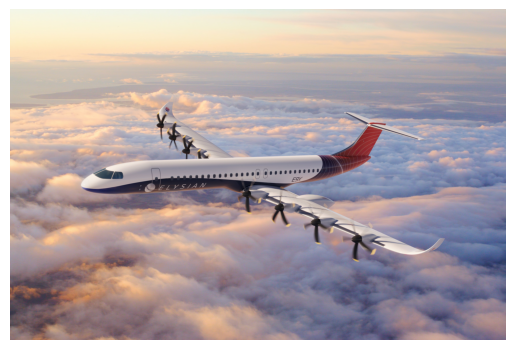

Predicted class: Airplane


In [8]:
from PIL import Image
import matplotlib.pyplot as plt

# Helper function to preprocess and display the image
def preprocess_and_show_image(image_path):
    transform = transforms.Compose([
        transforms.Resize((32, 32)),  # Resize the image to 32x32
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])
    
    # Open the image and preprocess it
    image = Image.open(image_path).convert("RGB")
    plt.imshow(image)  # Display the original image
    plt.axis("off")
    plt.show()
    
    # Transform for the model
    image = transform(image).unsqueeze(0)  # Add batch dimension
    return image.to(device)

# Upload and test your photo
image_path = "plane-2.jpg"  # Replace with the path to your photo
input_image = preprocess_and_show_image(image_path)

# Predict the class
with torch.no_grad():
    output = model(input_image)
    _, predicted_class = torch.max(output, 1)

# CIFAR-10 class names
class_names = [
    "Airplane", "Automobile", "Bird", "Cat", "Deer",
    "Dog", "Frog", "Horse", "Ship", "Truck"
]

print(f"Predicted class: {class_names[predicted_class.item()]}")